In [1]:
%matplotlib inline

# Familiar libraries.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn import cross_validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
import time

# Take a moment to install Theano.  We will use it for building neural networks.
import theano 
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
print theano.config.device # We're using CPUs (for now)
print theano.config.floatX # Should be 64 bit for CPUs

np.random.seed(0)

gpu
float32


Using gpu device 0: GeForce GTX 960


In [72]:
# Load the kaggle training dataset
all_train_data = np.genfromtxt("training.csv", delimiter=",", skip_header=1, usecols=(30)
                           , converters={ 30: lambda x : x.replace(" ", ",") })

# Convert all values to float and rescale from 0-1
# Theano is using float32, so downcast
all_train_data = np.array(map(lambda x : np.array(x.split(",")).astype(float), all_train_data), dtype=np.float32)
# all_train_data = all_train_data.reshape(all_train_data.shape[0], 1, 96, 96)
all_train_labels = np.genfromtxt("training.csv", delimiter=",", skip_header=1, usecols=np.arange(30), dtype=np.float32)

# Rescale our coordinates from -1 to 1
all_train_labels = (all_train_labels - 48) / 48
shuffle = np.random.permutation(np.arange(len(all_train_data)))

# Split training dataset into train, dev, test
train_data, train_labels = all_train_data[shuffle[:5000]], all_train_labels[shuffle[:5000]]
dev_data, dev_labels = all_train_data[shuffle[5000:6000]], all_train_labels[shuffle[5000:6000]]
test_data, test_labels = all_train_data[shuffle[6000:]], all_train_labels[shuffle[6000:]]

# Load the kaggle test dataset
kaggle_test_data = np.genfromtxt("test.csv", delimiter=",", skip_header=1, usecols=(1), \
    converters= { 1: lambda x : x.replace(" ", ",") }, dtype=np.float32)
kaggle_test_data = np.array(map(lambda x : np.array(x.split(",")).astype(float) / 255, kaggle_test_data), dtype=np.float32)

print train_data.shape
print train_labels.shape

(5000, 9216)
(5000, 30)


In [89]:
phi = 50
theta = 50
max_intensity = 1.0
all_train_data = (max_intensity/phi)*(all_train_data/(max_intensity/theta))**0.5

{0: 'left_eye_center_x', 1: 'left_eye_center_y', 2: 'right_eye_center_x', 3: 'right_eye_center_y', 4: 'left_eye_inner_corner_x', 5: 'left_eye_inner_corner_y', 6: 'left_eye_outer_corner_x', 7: 'left_eye_outer_corner_y', 8: 'right_eye_inner_corner_x', 9: 'right_eye_inner_corner_y', 10: 'right_eye_outer_corner_x', 11: 'right_eye_outer_corner_y', 12: 'left_eyebrow_inner_end_x', 13: 'left_eyebrow_inner_end_y', 14: 'left_eyebrow_outer_end_x', 15: 'left_eyebrow_outer_end_y', 16: 'right_eyebrow_inner_end_x', 17: 'right_eyebrow_inner_end_y', 18: 'right_eyebrow_outer_end_x', 19: 'right_eyebrow_outer_end_y', 20: 'nose_tip_x', 21: 'nose_tip_y', 22: 'mouth_left_corner_x', 23: 'mouth_left_corner_y', 24: 'mouth_right_corner_x', 25: 'mouth_right_corner_y', 26: 'mouth_center_top_lip_x', 27: 'mouth_center_top_lip_y', 28: 'mouth_center_bottom_lip_x', 29: 'mouth_center_bottom_lip_y'}


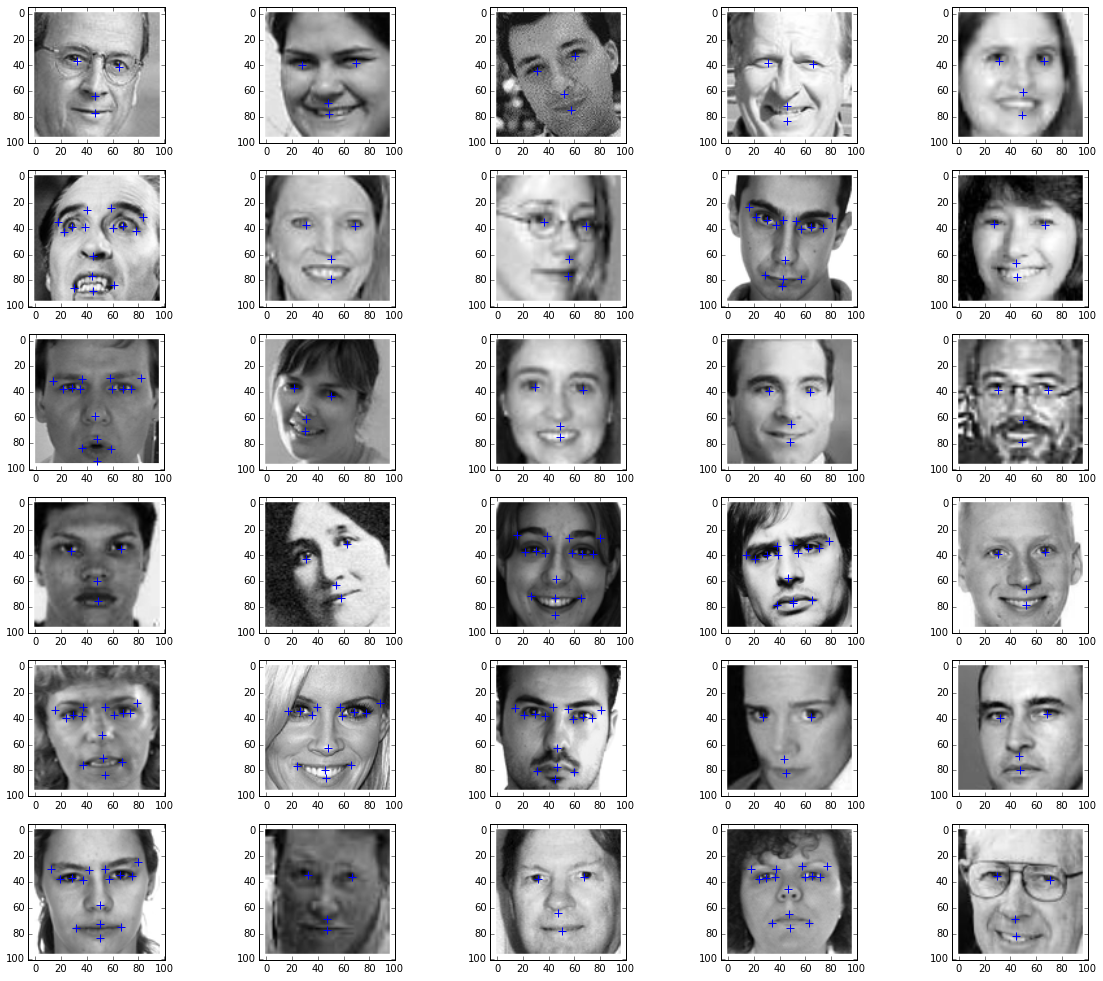

'picsplz' took 2.89 seconds


In [90]:
# Define some utility functions

# Build the feature name -> idx and idx -> feature_name mappings for easy translation
feature_dict = {}
idx_dict = {}

# Read the first entry in training.csv and split by commas
with open("training.csv", "r") as f:
  header = f.readline().strip().split(",")[:-1]
  feature_dict = dict(enumerate(header))
  idx_dict = { v: k for k, v in feature_dict.items() }

def stopwatch(f):
  """for timing stuff"""
  def timer(*args, **kw):
    start = time.time()
    result = f(*args, **kw)
    end = time.time()
    print '%r took %.2f seconds' % (f.__name__, end-start)
    return result

  return timer

@stopwatch
def picsplz(idxs, train_labels = train_labels, pred_labels = [], cols = 5):
  """given a list of indices, draws the images and their facial keypoints"""
  plt.figure(figsize = (20, 20))
  for i, j in enumerate(idxs):
    ax = plt.subplot(1 + (len(idxs) / cols), cols, i+1)
    x = train_data[j].reshape(96, 96)
    ax.imshow(x, cmap = "gray")
    # TODO expand this to color dot based on type of keypoint
    ax.scatter((train_labels[j][0::2] * 48) + 48, (train_labels[j][1::2] * 48) + 48, s=50, marker="+")
    # if we have predicted labels, then display them as red dots
    if len(pred_labels) > j:
      ax.scatter((pred_labels[j][0::2] * 48) + 48, (pred_labels[j][1::2] * 48) + 48, s=50, c="red", marker="+")
  plt.show()

def rmse(pred_labels, actual_labels):
  """compute rmse"""
  # set all missing features to 0 when doing rmse computation
  # this is debatable
  cases = ~np.isnan(actual_labels)
  return np.sqrt(mean_squared_error(actual_labels[cases], pred_labels[cases]))

# Sanity check: print out our feature dictionary
print feature_dict

# Show 30 random samples
picsplz(np.random.permutation(np.arange(len(train_data)))[:30])


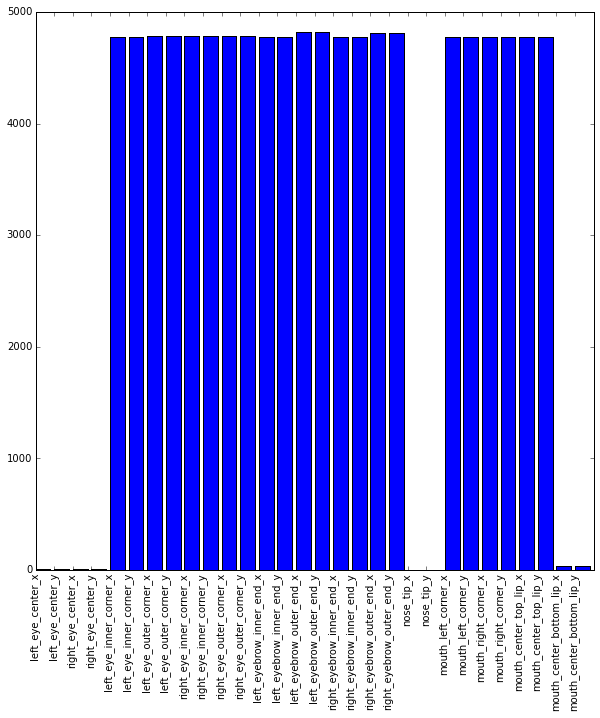

Number of complete cases: 2140


In [4]:
# Visualize number of occurrences of each keypoint
nans_per_keypoint = np.sum(np.isnan(all_train_labels.T), axis=1)
plt.figure(figsize=(10, 10))
plt.bar(range(30), nans_per_keypoint)
plt.xticks(range(30), feature_dict.values(), rotation='vertical')
plt.show()

# Print the number of complete cases
complete_cases = np.equal(np.sum(np.logical_not(np.isnan(all_train_labels)), axis=1), 30)
print "Number of complete cases: %d" % np.sum(complete_cases)

In [81]:
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

def model(**kwargs):
    train_data = kwargs['train_data']
    train_labels = kwargs['train_labels']
    test_data = kwargs['test_data']
    verbose = kwargs['verbose'] if 'verbose' in kwargs else 0
    
    complete_cases = np.equal(np.sum(np.logical_not(np.isnan(train_labels)), axis=1), 30)

    net1 = NeuralNet(
        layers=[  # three layers: one hidden layer
            ('input', layers.InputLayer),
            ('hidden', layers.DenseLayer),
            ('output', layers.DenseLayer),
            ],
        # layer parameters:
        input_shape=(None, 9216),  # 96x96 input pixels per batch
        hidden_num_units=500,  # number of units in hidden layer
        output_nonlinearity=None,  # output layer uses identity function
        output_num_units=30,  # 30 target values

        # optimization method:
        update=nesterov_momentum,
        update_learning_rate=0.01,
        update_momentum=0.9,

        regression=True,  # flag to indicate we're dealing with regression problem
        max_epochs=700,  # we want to train this many epochs
        verbose=verbose,
        )

    X = train_data[complete_cases]
    y = train_labels[complete_cases]

    net1.fit(X, y)
    pred_labels = net1.predict(test_data) 
    
    return (net1, pred_labels)

0.287538


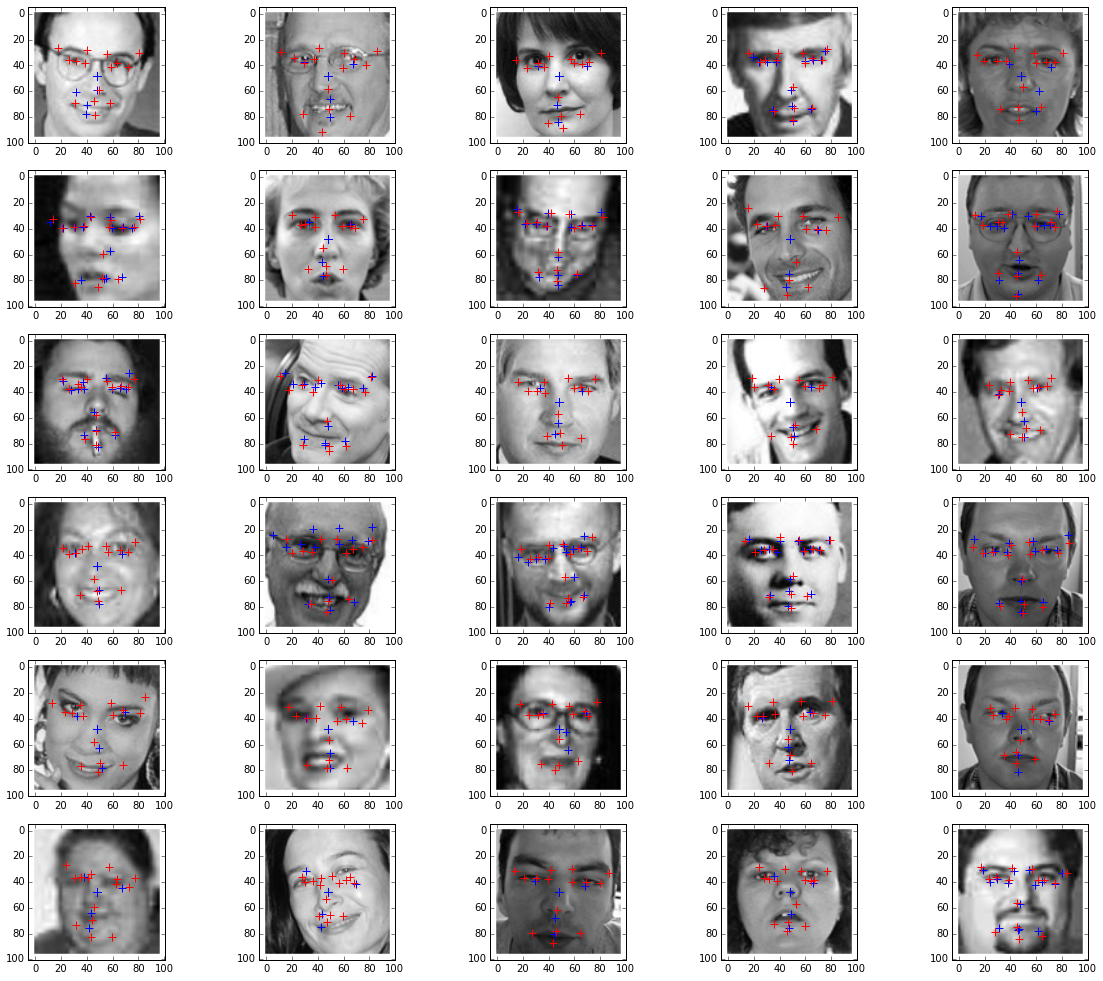

'picsplz' took 2.97 seconds


In [84]:
m, pred_labels = model(train_data = train_data, train_labels = train_labels, test_data = dev_data)
print rmse(pred_labels, dev_labels)

picsplz(np.random.permutation(np.arange(len(dev_labels)))[:30], dev_labels, pred_labels)

In [70]:
@stopwatch
def kaggleize(output, labels):
  """given a set of labels for the test set, output our results in the expected kaggle format"""

  assert len(labels) == 1783, "Expecting 1783 labels, found %d" % len(labels)

  with open("IdLookupTable.csv", "r") as f_in, open(output, "w") as f_out:
    # Skip first line, since it's the header
    f_in.readline()

    f_out.write("RowId,Location\n")
    for line in f_in:
      entry = line.strip().split(",")
      row = int(entry[0])
      idx = int(entry[1])
      feature = entry[2]
      location = round((labels[idx-1, idx_dict[feature]] * 48) + 48)
      # max value is 96 and min value is 0
      # rescale to the appropriate
      bounded_location = max(0, min(96, location))
      f_out.write("%d,%d\n" % (row, bounded_location))

In [73]:
# Evaluate our baseline against the entire training set and generate sample set
# Train our baseline
m, pred_labels = model(train_data = all_train_data, train_labels = all_train_labels, test_data = kaggle_test_data)

# Output our baseline results to kaggle format
kaggleize("output.csv", pred_labels)

# Profit!
print "done!"

  input             	(None, 9216)        	produces    9216 outputs
  hidden            	(None, 100)         	produces     100 outputs
  output            	(None, 30)          	produces      30 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    0.142237  |    0.075647  |     1.880273  |             |  0.1s
     2  |    0.047489  |    0.025506  |     1.861833  |             |  0.1s
     3  |    0.016984  |    0.014984  |     1.133453  |             |  0.1s
     4  |    0.013090  |    0.013363  |     0.979593  |             |  0.1s
     5  |    0.012181  |    0.012071  |     1.009172  |             |  0.0s
     6  |    0.011321  |    0.011379  |     0.994873  |             |  0.0s
     7  |    0.010808  |    0.010927  |     0.989070  |             |  0.0s
     8  |    0.010461  |    0.010568  |     0.989862  |             |  0.1s
     9  |    0.010173  |    0.010275  